# 02_prepare_transform.ipynb (During the pipeline)

"Preparing and running data transformation"


### A. Introduction

This section outlines the goals for this ETL stage. The objective is to prepare collected data before downstream steps (feature engineering and modeling). Transformation cleans, normalizes, and structures the collected textual and visual data.


In [1]:
import pandas as pd
from io import BytesIO
from common.storage import get_minio_client
from common.config import (
    FILE_LOAD,
    FILE_TRANSFORM,
    MINIO_BUCKET_LOAD,
    MINIO_BUCKET_TRANSFORM
)
from pipeline.transform.transform_data import run_transformation

### B. Running the transformation pipeline

This section executes the main transformation function defined in `src/pipeline/transform/transform_data.py`. It reads collected data from MinIO, applies cleaning and preparation steps, then saves the transformed data to the MinIO `transform` bucket.


In [2]:
print("\n=== Exécution du pipeline de transformation ===")
run_transformation()
print("\nTransformation terminée et sauvegardée dans MinIO.")


=== Exécution du pipeline de transformation ===

Transformation terminée et sauvegardée dans MinIO.


### C. Loading and validating transformed data

After transformation, we load the data from MinIO to verify the dataset structure (columns, data types, sample rows). This ensures transformations were applied correctly.


In [3]:
print("\n=== Chargement des données transformées ===")
client = get_minio_client()
data = client.get_object(MINIO_BUCKET_TRANSFORM, FILE_TRANSFORM)
df = pd.read_csv(BytesIO(data.read()))
data.close(); data.release_conn()

display(df.head())
print("\nStructure du DataFrame :")
print(df.info())


=== Chargement des données transformées ===


,id,title,link,image_url,extracted_text,found_images,title_length
0,1,/r/WorldNews Live Thread: Russian Invasion of ...,https://www.reddit.com/r/worldnews/comments/1o...,https://a.thumbs.redditmedia.com/jWqSTFxxKuo9a...,"A place for major news from around the world, ...",image/3b0c8940e7b0ed02202d45b7039eeecd73f98114...,85
1,2,President directs Pentagon to start testing nu...,https://www.reddit.com/r/worldnews/comments/1o...,https://external-preview.redd.it/nOXAnRphi9eQz...,"A place for major news from around the world, ...",image/3b0c8940e7b0ed02202d45b7039eeecd73f98114...,59
2,3,Trump cuts tariffs on China after meeting Xi i...,https://www.reddit.com/r/worldnews/comments/1o...,https://external-preview.redd.it/iYJFz_Xk-O9C4...,"A place for major news from around the world, ...",image/3b0c8940e7b0ed02202d45b7039eeecd73f98114...,59
3,4,“Unprecedented Threat To Earth”: 22 Of 34 Vita...,https://www.reddit.com/r/worldnews/comments/1o...,https://external-preview.redd.it/L4QPgWOiEDJy3...,"A place for major news from around the world, ...",image/3b0c8940e7b0ed02202d45b7039eeecd73f98114...,109
4,5,Trump says South Korea has approval to build n...,https://www.reddit.com/r/worldnews/comments/1o...,https://external-preview.redd.it/GPr5O_2hk2GAL...,"A place for major news from around the world, ...",image/3b0c8940e7b0ed02202d45b7039eeecd73f98114...,70



Structure du DataFrame :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              30 non-null     int64 
 1   title           30 non-null     object
 2   link            30 non-null     object
 3   image_url       30 non-null     object
 4   extracted_text  30 non-null     object
 5   found_images    30 non-null     object
 6   title_length    30 non-null     int64 
dtypes: int64(2), object(5)
memory usage: 1.8+ KB
None


### D. Statistical checks and additional cleaning

This step performs quality checks on transformed data. It looks for missing values and duplicates and computes descriptive statistics. A simple visualization (title length distribution) helps characterize the dataset.



=== Vérifications statistiques ===
Nombre de valeurs manquantes par colonne :
id                0
title             0
link              0
image_url         0
extracted_text    0
found_images      0
title_length      0
dtype: int64

Nombre de doublons : 0


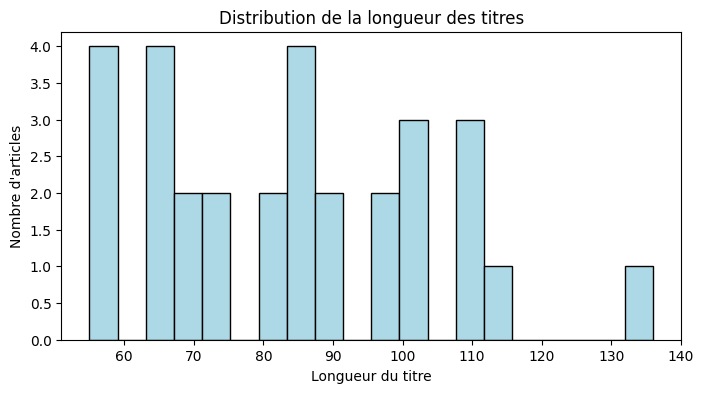

In [4]:
print("\n=== Vérifications statistiques ===")
print("Nombre de valeurs manquantes par colonne :")
print(df.isna().sum())

print("\nNombre de doublons :", df.duplicated().sum())

# Ajouter une colonne de longueur de titre si pertinente
df['title_length'] = df['title'].astype(str).apply(len)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.hist(df['title_length'], bins=20, color='lightblue', edgecolor='black')
plt.title('Distribution de la longueur des titres')
plt.xlabel('Longueur du titre')
plt.ylabel('Nombre d\'articles')
plt.show()

### E. Exporting validated data to MinIO

After validation, final data are exported to a new MinIO bucket (`load`). This file becomes the input for the next pipeline stage: feature creation and final loading.


In [6]:
print("\n=== Sauvegarde des données validées ===")
csv_bytes = df.to_csv(index=False).encode('utf-8')
client.put_object(
    bucket_name=MINIO_BUCKET_LOAD,
    object_name=FILE_LOAD,
    data=BytesIO(csv_bytes),
    length=len(csv_bytes),
    content_type="text/csv",
)
print(f"Fichier '{FILE_LOAD}' sauvegardé dans le bucket '{MINIO_BUCKET_LOAD}'.")


=== Sauvegarde des données validées ===
Fichier 'loaded_articles.csv' sauvegardé dans le bucket 'load'.


## Conclusion

This section closes the preparation process. The data have been cleaned, validated, and saved. They are now ready for downstream analysis: feature engineering, modeling, and pipeline evaluation.
